In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# plt.style.use('dark_background')
import h5py
import skopt
import scipy as sc
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
%run ./Functions_Test.ipynb
%run ./Val_Functions.ipynb
import matplotlib as mpl
import time
import math
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

### Dataset generation

In [5]:
#### Dataset loading

Ndim      = 9
idx       = range(Ndim)

Re        = 400
t_lyap    = 0.0163**(-1)    # Lyapunov time

downsample  = 4

hf       = h5py.File('./../data/MFE_Sri_RK4_dt=0.25_'+str(Re)+'kt=048.h5','r')
UU       = np.array(hf.get('q'))[:,::downsample]
hf.close()


N1_val = 10 #number of time series used during training

N0  = UU.shape[0]
N1  = UU.shape[1]
U   = UU.reshape(N0*N1, Ndim)
UUU = UU.copy()
print(UU.shape, U.shape)


#### Adding noise

# Set a target SNR in decibel
target_snr_db = 40
sig_avg_watts = np.var(U,axis=0) #signal power
sig_avg_db = 10 * np.log10(sig_avg_watts) #convert in decibel
# Calculate noise, then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.zeros(U.shape)
seed = 0                        #to be able to recreate the data
rnd  = np.random.RandomState(seed)
for i in range(Ndim):
    noise_volts[:,i] = rnd.normal(mean_noise, np.sqrt(noise_avg_watts[i]),
                                       U.shape[0])
UU  = U + noise_volts

UU  = UU.reshape(N0,N1,Ndim)
kinetic = 0.5*np.linalg.norm(U,axis=1)**2
print(np.mean(kinetic), np.std(kinetic))

#### data management

dt        = .25*downsample  # timestep 
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time
print(N_lyap, dt)

# number of time steps for washout, train, validation, test
N_washout = N_lyap
N_val     = 2*N_lyap
N_train   = N1 - N_val - N_washout 

print(N_train/N_lyap)

#compute norm
U_data = U[:N_washout+N_train+N_val]
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m

# washout
U_washout = UU[:N1_val,:N_washout]
# training
U_t   = UU[:N1_val,N_washout:N_washout+N_train-1]
Y_t   = UU[:N1_val,N_washout+1:N_washout+N_train]
# training + validation
U_tv  = UU[:N1_val,N_washout:N_washout+N_train+N_val-1]
Y_tv  = UU[:N1_val,N_washout+1:N_washout+N_train+N_val]
NN    = N1_val
k_tv  = 0.5*np.linalg.norm(Y_tv[:NN].reshape(NN*(N_train+N_val-1), Ndim), axis=1)**2
# validation
Y_v  = UU[:N1_val,N_washout+N_train:N_washout+N_train+N_val]

(1438, 4000, 9) (5752000, 9)
0.05985675025751997 0.0631508261395143
61 1.0
62.57377049180328


## Time series

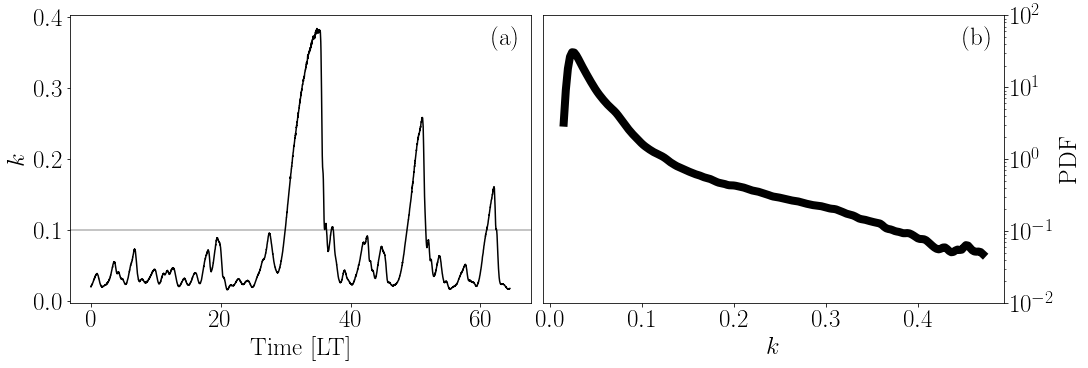

In [6]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
ax, fig = plt.subplots(1,2)

plt.subplot(121)
plt.axhline(0.1,color='k', alpha=.3)
plt.plot(np.arange(N_train+N_val-1)/N_lyap,
                  0.5*np.linalg.norm(U_tv[5,:,idx].T,axis=1)**2, c='k')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylabel('$k$')
plt.xlabel('Time [LT]')

axx = plt.subplot(122)
N_range=(0.015,0.48)
N_rang1=(0.015,N_range[1]-0.01)
plt.ylim(0.01,100)
axx.yaxis.set_label_position("right")
axx.yaxis.tick_right()
Y_stats = kinetic
mask    = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats = Y_stats[mask]
density1 = sc.stats.gaussian_kde(Y_stats)
n, y, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
                   histtype=u'step', density=True, log=True, alpha=0.001, color='k')
dy      = density1(y)
plt.plot(y, dy, label='True', linewidth=8, c='black')
plt.xlabel('$k$')
plt.ylabel('PDF')
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax.tight_layout(pad=0.12)
plt.savefig('k_time_pdf.pdf')

plt.show()

## Control

(0.015, 0.47)
(0.015, 0.47)
(0.012, 0.47)
(0.012, 0.47)
(0.012, 0.47)


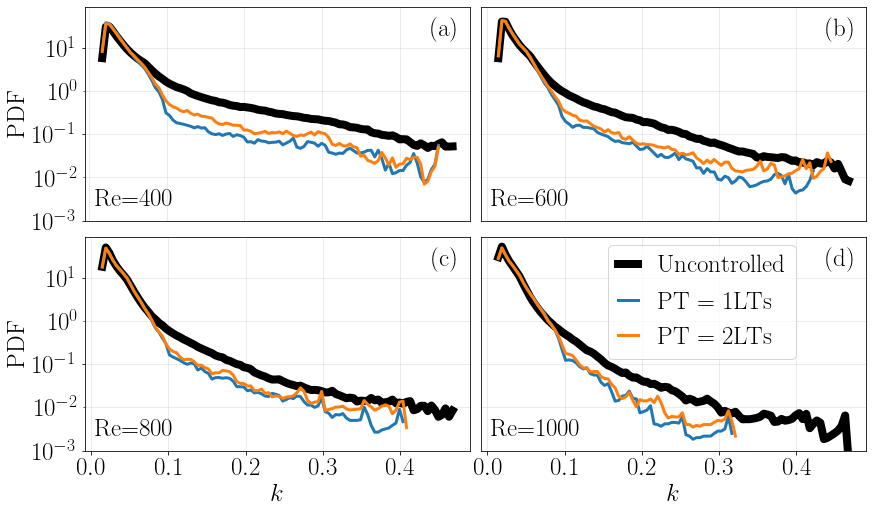

In [11]:
NN_units = [2000]
vals     = [RVC]
SNRs     = [40]
Res      = [400,600,800,1000]
# target_snr_db = SNRs[0]

N_preds = [1,2]

fln = './../data/400_'+ vals[0].__name__ + '_New_Control_'+ str(N_preds[0]) + '_'  + str(NN_units[0]) +'.h5'
hf        = h5py.File(fln,'r')
range_0,range_1,bins     = np.array(hf.get('Parameters'))
hf.close()

bins = int(bins)
N_range=(range_0,range_1)
N_rang1=(N_range[0],N_range[1]-0.01)
print(N_rang1)

Y_stats  = kinetic
mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats  = Y_stats[mask]
n, y     = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)
y        = y[:-1]+(y[1]-y[0])/2

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams["font.size"] = 25

letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

plt.plot(y, n, label='Uncontrolled', linewidth=8, c='black')

len_Re = len(Res)
for i in range(len_Re):
    ax = plt.subplot(2,2,i+1)
    
    hf       = h5py.File('/data/ar994/Python/data/MFE/MFE_Sri_RK4_dt=0.25_' \
                         + str(Res[i]) + 'kt=048.h5','r')
    UU       = np.array(hf.get('q'))[:,::4,idx]
    hf.close()
    
    fln = './../data/'+ str(Res[i]) + '_' + vals[0].__name__ + '_New_Control_1_'  + str(NN_units[0]) +'.h5'
    hf        = h5py.File(fln,'r')
    range_0,range_1,bins     = np.array(hf.get('Parameters'))
    hf.close()
    
    bins = int(bins)
    N_range=(range_0,range_1)
    N_rang1=(N_range[0],N_range[1]-0.01)
    print(N_rang1)

    Y_stats   = (0.5*np.linalg.norm(UU,axis=2)**2).flatten()
    mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
    Y_stats  = Y_stats[mask]
    n, y     = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)
    y        = y[:-1]+(y[1]-y[0])/2
        
    plt.plot(y, n, label='Uncontrolled', linewidth=8, c='black')

    for N_pred in N_preds:

        fln = './../data/'+ str(Res[i]) + '_' + vals[0].__name__ + '_New_Control_'+ str(N_pred) + '_'  + str(NN_units[0]) +'.h5'
        hf        = h5py.File(fln,'r')
        hists     = np.array(hf.get('temp'))
        range_0,range_1,bins     = np.array(hf.get('Parameters'))
        hf.close()

        bins = int(bins)
        N_range=(range_0,range_1)
        N_rang1=(N_range[0],N_range[1]-0.01)
        bin_x  = np.linspace(N_rang1[0],N_rang1[1],bins+1)
        bin_x  = bin_x[:-1]+(bin_x[1]-bin_x[0])/2
        
        if i == len_Re -1 :
            hist_plot = hists[3].copy()
        else:
            hist_plot = hists[3].copy()
        hist_nz   = np.nonzero(hist_plot)[0]

        plt.plot(bin_x[hist_nz], hist_plot[hist_nz], label='PT = '+str(N_pred)+'LTs', linewidth=3)

    plt.yscale('log')
    if (i%2) == 0:
        plt.ylabel('PDF')
    else:
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
    
    if i == len_Re-1:
        plt.legend(labelspacing=.5, bbox_to_anchor=(0.85,1.02), frameon=True, handlelength=.8,
           loc='upper right', fontsize=25)
    
    if i < len_Re-2:
        plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
    else:
        plt.xlabel('$k$')
        
    plt.annotate('Re='+ str(Res[i]), xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
    plt.annotate(letter[i], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points', fontsize=25)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(.1))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.,numticks=15))
    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
    plt.ylim(0.001,90)

    plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
#need to run Stats_run to obtain the data for this cell
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [SSV,RVC]
SNRs     = [40]
# target_snr_db = SNRs[0]
ensemble = 10

bins      = 200
errors    = np.zeros((ensemble,len(NN_units),len(vals), len(SNRs)))
hists     = np.zeros((ensemble,len(NN_units),len(vals), len(SNRs), bins))

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

print(str(N_rang1))

# Test
Y_stats  = kinetic
mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats  = Y_stats[mask]
density1 = sc.stats.gaussian_kde(Y_stats)
n, y     = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)
dy       = density1(y)

# Short Test
Y_stats   = kinetic[:200*N1]
mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats   = Y_stats[mask]
n1        = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)[0]
err_short = (np.abs(n1-n)/n).mean()

# Train
Y_stats   = k_tv
mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats   = Y_stats[mask]
density0  = sc.stats.gaussian_kde(Y_stats)
nn        = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)[0]
dyy       = density0(y)
err_train = (np.abs(nn-n)/n).mean()

k_u       = 0

for N_units in NN_units:
        
    k_t = 0
        
    for target_snr_db in SNRs:
        
        k_v   = 0
        for j in vals:
            
            #these files are missing from the repository, you need to run Stats_Run with the relevant cases
            #they are missing because they are too large
            fln = '/../data/' \
                      + j.__name__ + '_Statss_' + str(target_snr_db) + '_' + str(N_units) + '.h5'
            hf = h5py.File(fln,'r')
            Y_stats = np.array(hf.get('Y_stats'))[:]
            hf.close()

            b  = 0
            kk = 0
            for jj in range(Y_stats.shape[0]):
                k  = 0
                k1 = 0
                a  = 0.5*np.linalg.norm(Y_stats[jj],axis=2)**2
                for i in range(a.shape[0]):

                    minn = a[k,-10*N_lyap:-1].min()
                    maxx = a[k,-10*N_lyap:-1].max()
                    if (maxx - minn < 0.01 and minn > 0.05) or a[k].max() > 0.48:
                        a = np.delete(a,k,axis=0)
                        k  += -1
                        k1 += 1

                    k += 1

                kk += k1

                if a.shape[0] > 0:
                    Y_statss               = a.flatten() 
                    mask                   = (Y_statss < N_range[1]) & (Y_statss > N_range[0])
                    Y_statss               = Y_statss[mask]
                    hists[jj,k_u,k_v,k_t]  = np.histogram(Y_statss, bins=bins,
                                                      range=N_rang1,density=True)[0]
                    errors[jj,k_u,k_v,k_t] = (np.abs(hists[jj,k_u,k_v,k_t]-n)/n).mean()

                b = np.append(b,a.flatten())

            Y_stats     = b 
            mask        = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
            Y_stats     = Y_stats[mask]
            density2    = sc.stats.gaussian_kde(Y_stats)
            dyyy        = density2(y)
            plt.plot(y, dyyy, label=labels[k_v], c=colors[k_v], linewidth=3, alpha=0.8)

            print(j.__name__, target_snr_db, N_units, kk/(i+1)/(jj+1))
            k_v         += 1

        k_t += 1
    
        k_u += 1
    
plt.legend(ncol=2)
plt.tight_layout(pad=0.1)
plt.savefig('Stats_' + str(N_rang1) + '.pdf')

fln = './data/Stats_' + str(N_rang1) + '.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('rel-err',data=errors)
hf.create_dataset('bins'   ,data=hists)
hf.create_dataset('edges'  ,data=y)
hf.create_dataset('true',    data=n)
hf.create_dataset('train',   data=nn)
hf.create_dataset('short',   data=n1)
hf.close()

plt.show()


RV 2000 0.0829798957118217
Train 0.5725588146206431


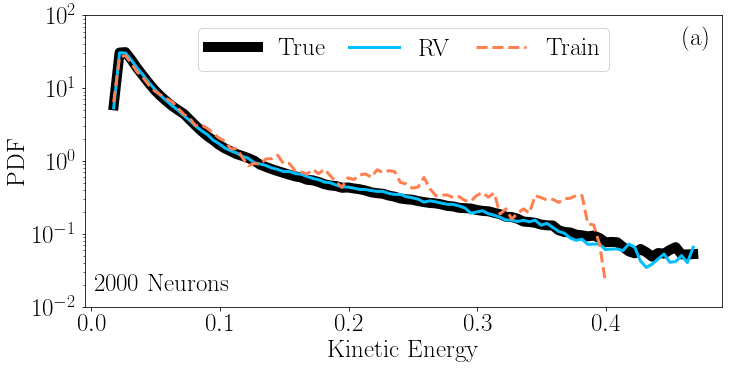

In [14]:
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [RVC]
SNRs     = [40]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

# to obtain this, need to run cell above
fln       = './../data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['s', 'o', '^', 'v']
labels  = [ 'RV']
colors  = ['deepskyblue']


plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25

if new:
    n_new = (n[::2]+n[1::2])/2
    y     = y[1::2]
else:
    n_new = n
    y     = y[:-1] + (y[1]-y[0])/2


for i in range(3,4):
    
    plt.subplot(1,1,1)
    
    plt.plot(y, n_new, label='True', linewidth=10, c='black')
    plt.ylabel('PDF')
    
    for k in range(snr_length):
    
        for j in range(1,1+vl_length):
            errr = errors[:,i,j,k].copy()
    #         errr[np.where(errr == 0)[0]] = 10
            temp    = np.argsort(errr)
            temp    = temp[ensemble-np.nonzero(errr)[0].shape[0]:]
#             histmin = hists[temp[temp.shape[0]//2] ,i,j,k]
            histmin = hists[np.argmin(errr) ,i,j,k]
            if new:
                hist_new = (histmin[::2]+histmin[1::2])/2
            else:
                hist_new = histmin.copy()
            
            print(labels[j-1], NN_units[i], (np.abs(hist_new-n_new)/n_new).mean())
            plt.plot(y, hist_new, c=colors[j-1], label=labels[j-1],
                    linewidth=3)
                    
    if new:
        nn_new = (nn[::2]+nn[1::2])/2
    else:
        nn_new = nn
    plt.plot(y[np.nonzero(nn_new)[0]], nn_new[np.nonzero(nn_new)[0]],
             '--', color='coral', label='Train', linewidth=3, alpha=1.)
    print('Train', (np.abs(nn_new-n_new)/n_new).mean())
    
    plt.annotate(str(NN_units[i]) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points')
    plt.ylim(0.01,100)
    plt.yscale('log')
    plt.xlabel('Kinetic Energy')
    
plt.legend(ncol=3, loc='upper center', columnspacing=1)
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.tight_layout(pad=0.1)

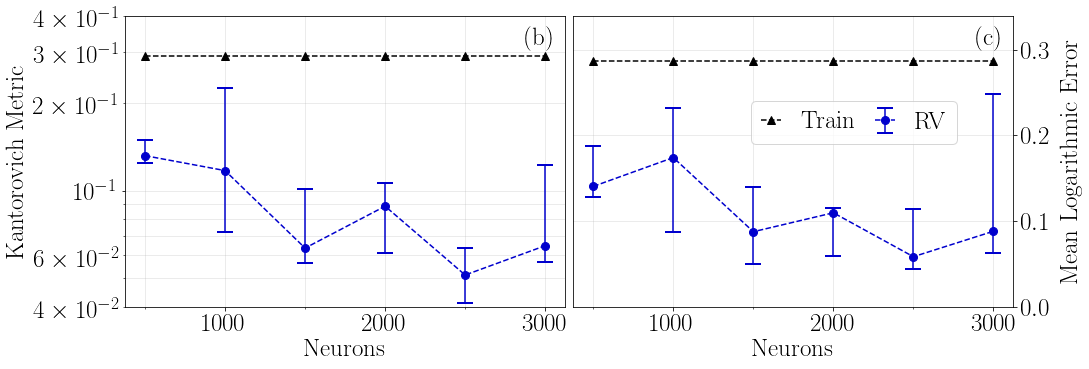

In [24]:
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [RVC]
SNRs     = [40]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = './../data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['o', '^', 'v']
labels  = ['RV']
colors  = ['mediumblue']

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
plt.figure()
ax = plt.subplot(1,2,1)

err_train = sc.stats.wasserstein_distance(n, nn)
err_short = sc.stats.wasserstein_distance(n, n1)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
plt.plot(NN_units, err_train*np.ones(un_length), c='k', linestyle='--', label='Train',
        marker='^', markersize=8)

plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(1,1+vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            for k in range(ensemble):
                errr[k]  = sc.stats.wasserstein_distance(n, hists[k,i,j,l])
            errr    = errr[np.nonzero(hists[:,i,j,l])[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j-1], marker=markers[j-1], markersize=8,
                 capsize=8, capthick=2, label=labels[j-1], alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[j-1])
        
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.xlabel('Neurons')
plt.ylim(.04,.4)
plt.ylabel('Kantorovich Metric')

ax = plt.subplot(1,2,2)

err_train = (np.abs(nn-n)/n).mean()
err_short = (np.abs(n1-n)/n).mean()
pwr       = 1
n2        = nn.copy()
# print(np.where(n2 == 0)[0]) #bins for which the training set has no values
n2[np.where(n2 == 0)[0]] = \
            n[np.where(n2 == 0)[0]]*10**pwr
plt.plot(NN_units, np.abs(np.log10(n)-np.log10(n2)).mean()*np.ones(un_length), c='k', linestyle='--', label='Train',
        marker='^', markersize=8)
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(1,1+vl_length): #because there is SSV as first one
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            temp    = hists[:,i,j,l].copy()
            for k in range(ensemble):
                hists[k,i,j,l][np.where(hists[k,i,j,l] == 0)[0]] = \
                n[np.where(hists[k,i,j,l] == 0)[0]]*10**pwr
                errr[k] = np.abs(np.log10(n)-np.log10(hists[k,i,j,l])).mean()
#             errr[np.where(errr == 0)[0]] = 10
            errr    = errr[np.nonzero(temp)[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            if i==0:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j-1], marker=markers[j-1], markersize=8,
                 capsize=8, capthick=2, label=labels[j-1], alpha=1)
            else:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j-1], marker=markers[j-1], markersize=8,
                 capsize=8, capthick=2, alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[j-1])

plt.annotate('(c)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.ylabel('Mean Logarithmic Error', labelpad=10)
ax.yaxis.set_label_position("right")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.tick_right()
plt.xlabel('Neurons')
plt.ylim(.0,.34)
plt.legend(ncol=3, columnspacing=0.8, handlelength=0.8, bbox_to_anchor=(0.9,.75),
           loc='upper right')

plt.tight_layout(pad=0.1)
plt.savefig('Stats_Noise_' + str(np.array(N_rang1)) + '.pdf')

## Statistics of the velocity flowfield

In [ ]:
fln = './data/V_mean.h5'
hf = h5py.File(fln,'r')
um = np.array(hf.get('u_x'))
hf.close()

X       = np.linspace(0,4*math.pi,um.shape[0]) 
Y       = np.linspace(0,1,um.shape[1])
Z       = np.linspace(0,2*math.pi,um.shape[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z = XX
M       = MFE_modes(XX)


UU_tv  = U_tv.reshape(N1_val*(N_train+N_val-1), Ndim)
print(M[:,0].shape, UU_tv.shape, np.tensordot(M[:,0], UU_tv, axes=[[0], [1]]).shape)

uv    = False
mom   = False
power = 1

if uv:
    vx_mean  = (np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])*
               np.tensordot(M[:,1], UU_tv, axes=[[0], [1]])).mean(axis=(0,2,3))
else:
    AA       = np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])
    if mom: AA += - np.stack([um]*UU_tv.shape[0],axis=3)
    BB       = AA.copy()
    for p in range(power-1):
        BB *= AA
    vx_mean = (BB).mean(axis=(0,2,3))


vxx_mean = 0
v_mean   = 0
b        = U[:N1*500].copy()
den      = 10
idd      = b.shape[0]//den
print(b.shape)
for ii in range(den):
    if uv:
        vxx_mean += (np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])*
                     np.tensordot(M[:,1],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])
                     ).mean(axis=(0,2,3))/den
    else:
        AA        = np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])
        if mom: AA += - np.stack([um]*idd,axis=3)
        BB        = AA.copy()
        for p in range(power-1):
            BB   *= AA #need to be this way to use multicore, no np.power
        vxx_mean += (BB).mean(axis=(0,2,3))/den

# v_mean computed with power equal to 1        
#     v_mean += np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]]).mean(axis=3)/den  

# fln = './data/V_mean.h5'
# hf = h5py.File(fln,'w')
# hf.create_dataset('u_x'   ,data=v_mean)
# hf.close()

In [ ]:
#run Stats_Runs to get Statss files
val       = [SSV, RVC]
NN_units  = [500,1000,1500,2000,2500,3000]

ensemble  = 10

vesn_mean = np.zeros((ensemble, len(NN_units), len(val), Y.shape[0])) 
Nbs       = np.zeros((ensemble, len(NN_units), len(val))) 

# needs to be averages only on axis=3 (time)
# fln    = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
# hf     = h5py.File(fln,'r')
# um_esn = np.array(hf.get('vesn'))
# hf.close()

k1 = 0
for N_units in NN_units:
    k2 = 0
    for j in val:

        fln = '/../data/' \
              + j.__name__ + '_Statss_40_' + str(N_units) + '.h5'
        hf = h5py.File(fln,'r')
        Yy = np.array(hf.get('Y_stats'))[:]
        hf.close()
        print(j.__name__, N_units)

        vens       = np.zeros((Yy.shape[0], Y.shape[0]))
        Nb         = np.zeros(Yy.shape[0])
        for ii in range(Yy.shape[0]):

            k  = 0
            a  = 0.5*np.linalg.norm(Yy[ii],axis=2)**2
            b  = Yy[ii].copy()
            for i in range(a.shape[0]):

                minn = a[i,-5*N_lyap:-1].min()
                maxx = a[i,-5*N_lyap:-1].max()
                if (maxx - minn < 0.01 and minn > 0.05) or a[i].max() > 0.48:
                    b = np.delete(b,k,axis=0)
                    k  += -1
                k += 1

            Nb[ii]        = b.shape[0]*b.shape[1]
            Nbs[ii,k1,k2] = Nb[ii]*1
            b             = b.reshape(int(Nb[ii]), Ndim)

            if b.shape[0] > 0:
                den        = 4
                idd        = b.shape[0]//den
                vens [ii]  = 0
                for iii in range(den):
                    if uv:
                        vens[ii] += (np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])*
                                     np.tensordot(M[:,1],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                                     ).mean(axis=(0,2,3))/den
                    else:
                        AA        = np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                        if mom: AA += - np.stack([um]*idd,axis=3)
                        BB        = 1
                        for p in range(power):
                            BB   *= AA #need to be this way to use multicore, no np.power
                        vens[ii] += BB.mean(axis=(0,2,3))/den
                        
            vesn_mean[ii,k1,k2]   = vens[ii].copy() 
            
        k2              += 1
    k1              += 1
    
fln = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('vesn'   ,data=vesn_mean)
hf.create_dataset('weights',data=Nbs)
hf.create_dataset('vtrue'  ,data=vxx_mean)
hf.create_dataset('vtrain' ,data=vx_mean)
hf.close()

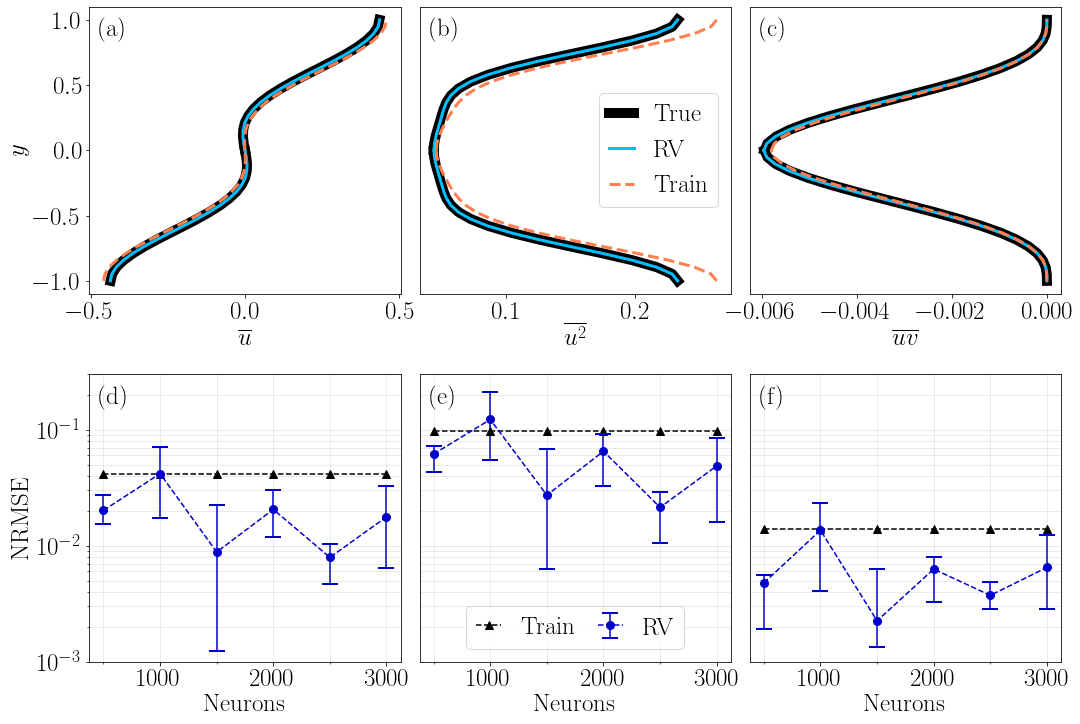

In [26]:
#run cells above to get V_mean and different Vesn
fln = './../data/V_mean.h5'
hf = h5py.File(fln,'r')
um = np.array(hf.get('u_x'))
hf.close()

X       = np.linspace(0,4*math.pi,um.shape[0]) 
Y       = np.linspace(0,1,um.shape[1])
Y1      = np.linspace(-1,0,um.shape[1])   
Z       = np.linspace(0,2*math.pi,um.shape[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z   = XX
M         = MFE_modes(XX)
val       = [RVC]
NN_units  = [500,1000,1500,2000,2500,3000]
ensemble  = 10
letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']


pwr       = [1,2,10] #10 is fictitious to indicate uv
pwr_len = len(pwr)
mom = False

x_labels   = ['$\overline{u}$', '$\overline{u^2}$', '$\overline{uv}$']

plt.rcParams["figure.figsize"] = (5*pwr_len,10)
plt.rcParams["font.size"] = 25

plt.subplots(2,pwr_len)


q1        = .25
q2        = 1 - q1


def flip_plot(a):
    if (power%2) == 0:
        a = np.flip(a)
    else:
        a = -np.flip(a)
    return a

for ii in range(pwr_len):
    
    power = pwr[ii]
    
    plt.subplot(2,pwr_len,ii+1)

    fln = './../data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
    hf = h5py.File(fln,'r')
    vesn_mean = np.array(hf.get('vesn'))
    Nbs       = np.array(hf.get('weights'))
    vxx_mean  = np.array(hf.get('vtrue'))
    vx_mean   = np.array(hf.get('vtrain'))
    hf.close()
    norm      = vxx_mean.max() - vxx_mean.min()

    un_length = len(NN_units)
    vl_length = len(val)

    errors    = np.zeros((ensemble,len(NN_units),len(val)+1))

    markers = ['o', '^', 'v']
    labels    = ['RV']
    colors  = ['deepskyblue']

    i_plot=4

    for i in np.arange(un_length): #plotting all the units

        if i == i_plot:
            plt.plot(flip_plot(vxx_mean),Y1, c='k', linewidth=10)
            plt.plot(vxx_mean,Y, label='True', c='k', linewidth=10)
            plt.annotate(letter[ii], xy=(0, 1), xytext=(10, -10), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')


        for j in range(1,1+vl_length): #plotting all the val functions
            errors[:,i,j] = np.sqrt(np.square(vesn_mean[:,i,j]-vxx_mean).mean(axis=1))/norm
            temp    = np.argsort(errors[:,i,j])
            temp    = temp[ensemble-np.nonzero(errors[:,i,j])[0].shape[0]:]

            vv_mean = vesn_mean[temp[temp.shape[0]//2],i,j]
            vv_mean = vesn_mean[np.argmin(errors[:,i,j]),i,j]
            if i==i_plot:
                plt.plot(vv_mean, Y, label = labels[j-1], c=colors[j-1], linewidth=3)
                plt.plot(flip_plot(vv_mean), Y1, c=colors[j-1], linewidth=3)

        if i==i_plot:
            plt.plot(vx_mean, Y, '--', color='coral', label ='Train', linewidth=3, alpha=1)
            plt.plot(flip_plot(vx_mean), Y1, '--', color='coral', linewidth=3, alpha=1)
            plt.xlabel(x_labels[ii]),
            if ii == 1:
                plt.legend(ncol=1,columnspacing=0.9,handlelength=1,fontsize=25,)
            
        if ii > 0:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
        else:
            plt.ylabel('$y$')
            
        err_train = np.sqrt(np.square(vx_mean-vxx_mean).mean())/norm
        
    
    ax = plt.subplot(2,pwr_len,pwr_len+ii+1)
    plt.yscale('log')
    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
    plt.plot(NN_units, err_train*np.ones(un_length), c='k', linestyle='--', label='Train',
            marker='^', markersize=8)

    markers = ['o', '^', 'v']
    colors  = ['mediumblue']

    for j in range(1,1+vl_length):
        a           = np.zeros(un_length)
        for i in range(un_length):
            errr    = errors[:,i,j][np.nonzero(Nbs[:,i,j])]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            if i==0:
                plt.errorbar(NN_units[i], a[i], 
                     yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                     linestyle='--', c=colors[j-1], marker=markers[j-1], markersize=8,
                     capsize=8, capthick=2, label=labels[j-1], alpha=1)
            else:
                plt.errorbar(NN_units[i], a[i], 
                     yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                     linestyle='--', c=colors[j-1], marker=markers[j-1], markersize=8,
                     capsize=8, capthick=2, alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[j-1])
    
    if ii > 0:
        u=10
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
        if ii==1:
            plt.legend(ncol=3,columnspacing=0.9,handlelength=1,fontsize=25, loc='lower center')
    else:
        plt.ylabel('NRMSE')
    plt.annotate(letter[pwr_len+ii], xy=(0, 1), xytext=(10, -10), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')
    plt.xlabel('Neurons')
    plt.ylim(0.001,0.3)
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))

plt.tight_layout(pad=0.2, h_pad=1.)


## 2D Flowfield

In [ ]:
# run Stats_Run to have the Statss files
val       = [RVC]
NN_units  = [2000]

ensemble  = 10

if uv:
    vesn_mean = np.zeros((ensemble, len(NN_units), len(val), um[0]-2,um[2]-2)) 
else:
    vesn_mean = np.zeros((ensemble, len(NN_units), len(val), um[0],um[2])) 

Nbs       = np.zeros((ensemble, len(NN_units), len(val))) 

k1 = 0
for N_units in NN_units:
    k2 = 0
    for j in val:

        fln = '/../data/' \
              + j.__name__ + '_Statss_40_' + str(N_units) + '.h5'
        hf = h5py.File(fln,'r')
        Yy = np.array(hf.get('Y_stats'))[:]
        hf.close()
        print(j.__name__, N_units)
        
        if uv:
            vens       = np.zeros((Yy.shape[0], um[0]-2,um[2]-2))
        else:
            vens       = np.zeros((Yy.shape[0], um[0],um[2]))
                
        Nb         = np.zeros(Yy.shape[0])
        for ii in range(Yy.shape[0]):

            k  = 0
            a  = 0.5*np.linalg.norm(Yy[ii],axis=2)**2
            b  = Yy[ii].copy()
            for i in range(a.shape[0]):

                minn = a[i,-5*N_lyap:-1].min()
                maxx = a[i,-5*N_lyap:-1].max()
                if (maxx - minn < 0.01 and minn > 0.05) or a[i].max() > 0.48:
                    b = np.delete(b,k,axis=0)
                    k  += -1
                k += 1

            Nb[ii]        = b.shape[0]*b.shape[1]
            Nbs[ii,k1,k2] = Nb[ii]*1
            b             = b.reshape(int(Nb[ii]), Ndim)
            print(b.shape)

            if b.shape[0] > 0:
                den        = 4
                idd        = b.shape[0]//den
                vens [ii]  = 0
                for iii in range(den):
                    if uv:
                        ux      = np.tensordot(M[:,0], b[iii*idd:(iii+1)*(idd)],
                                               axes=[[0], [1]])[:,0]
                        uz      = np.tensordot(M[:,2], b[iii*idd:(iii+1)*(idd)],
                                               axes=[[0], [1]])[:,0]

                        ux      = (ux[1:-1,2:] - ux[1:-1,:-2])/(2*(Z[1]-Z[0])) #dux_dz
                        uz      = (uz[2:,1:-1] - uz[:-2,1:-1])/(2*(X[1]-X[0])) #duz_dx
                        
                        BB        = 1
                        for p in range(power):
                            BB   *= (uz - ux)
                        vens[ii] += BB.mean(axis=(2))/den
                        
                    else:
                        AA        = np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                        if mom: AA += - np.stack([um]*idd,axis=3)
                        BB        = 1
                        for p in range(power):
                            BB   *= AA #need to be this way to use multicore, no np.power
                        vens[ii] += (BB[:,0]).mean(axis=(2))/den
                        
            vesn_mean[ii,k1,k2]   = vens[ii].copy() 
            
#         vesn_mean[k1,k2] = np.average(vens, axis=0, weights=Nb)
        k2              += 1
    k1              += 1

    
if uv:
    fln = './data/Vesn_flow' + str(mom) + '_' + str(power)+'_vort.h5' 
else:   
    fln = './data/Vesn_flow' + str(mom) + '_' + str(power)+'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('vesn'   ,data=vesn_mean)
hf.create_dataset('weights',data=Nbs)
hf.create_dataset('vtrue'  ,data=vxx_mean)
hf.create_dataset('vtrain' ,data=vx_mean)
hf.close()

Mean Training error 0.0018585840371086683
Mean ESN      error 0.00045875759648186863


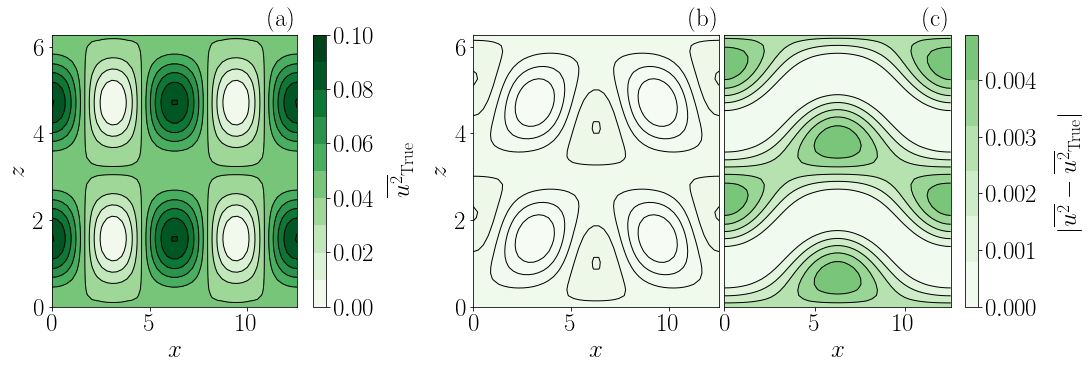

In [30]:
#run cells above to get Vesn_flow
from matplotlib.gridspec import *

um      = [50,2,50]

X       = np.linspace(0,4*math.pi,um[0]) 
Y       = np.linspace(0,1,um[1])
Z       = np.linspace(0,2*math.pi,um[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z = XX
M       = MFE_modes(XX)

val       = [RVC]
NN_units  = [2000]
ensemble  = 10
letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']


pwr       = [2]
pwr_len = len(pwr)
mom = False

x_labels   = ['$\overline{u}$', '$\overline{u^2}$', '$\overline{uv}$']

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

for ii in range(pwr_len):
    
    power = pwr[ii]
    
    fln = './../data/Vesn_flow' + str(mom) + '_' + str(power)+'.h5'
    hf = h5py.File(fln,'r')
    vesn_mean = np.array(hf.get('vesn'))
    Nbs       = np.array(hf.get('weights'))
    vxx_mean  = np.array(hf.get('vtrue'))
    vx_mean   = np.array(hf.get('vtrain'))
    hf.close()

    un_length = len(NN_units)
    vl_length = len(val)

    errors    = np.zeros((ensemble,len(NN_units),len(val)))

    markers = ['o', '^', 'v']
    labels  = ['RV']
    colors  = ['deepskyblue']
    
    vmin    = vxx_mean.min()
    vmax    = vxx_mean.max()
    
    vmin1    = vxx_mean.min()/10
    vmax1    = vxx_mean.max()/10
    
    arg_ens  = 0
    
    axx = plt.figure()
    gs  = GridSpec(1, 2, width_ratios=[1.15, 2.], figure=axx, wspace=0.02,hspace=0.1)
    gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], wspace=0.02, hspace=0.02,
                                  width_ratios=[1., 1.15])

    
    ax = axx.add_subplot(gs[0])
    CS     = plt.contourf(XX[0][:,0,:], XX[2][:,0,:], vxx_mean,levels=10,cmap='Greens',
                          vmin=vmin,vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label('$\overline{u^2}_{\mathrm{True}}$',labelpad=15)
    CS    = plt.contour(XX[0][:,0,:], XX[2][:,0,:], vxx_mean,levels=10,colors='black',
                                  linewidths=1, linestyles='solid',vmin=vmin,vmax=vmax)
    plt.xlabel('$x$')

    plt.ylabel('$z$')
    plt.annotate('(a)', xy=(1, 1), xytext=(0, +3), va='bottom', ha='right', xycoords='axes fraction', textcoords='offset points', color='black')
        
    ax = axx.add_subplot(gs1[0])
    CS     = plt.contourf(XX[0][:,0,:], XX[2][:,0,:], np.abs(vesn_mean[arg_ens,0,0]-vxx_mean)
                          ,levels=6,cmap='Greens',
                          vmin=vmin1,vmax=vmax1)
    CS    = plt.contour(XX[0][:,0,:], XX[2][:,0,:], np.abs(vesn_mean[arg_ens,0,0]-vxx_mean),
                        levels=6,colors='black',
                                  linewidths=1, linestyles='solid',vmin=vmin1,vmax=vmax1)
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.annotate('(b)', xy=(1, 1), xytext=(0, +3), va='bottom', ha='right', xycoords='axes fraction', textcoords='offset points', color='black')
    
    ax = axx.add_subplot(gs1[1])
    CS     = plt.contourf(XX[0][:,0,:], XX[2][:,0,:], np.abs(vx_mean-vxx_mean)
                          ,levels=6,cmap='Greens',
                          vmin=vmin1,vmax=vmax1)
    cbar = plt.colorbar(ticks=np.linspace(0,.005,6))
    cbar.set_label('$|\overline{u^2}-\overline{u^2}_{\mathrm{True}}|$',labelpad=15)
    CS    = plt.contour(XX[0][:,0,:], XX[2][:,0,:], np.abs(vx_mean-vxx_mean),levels=6,colors='black',
                                  linewidths=1, linestyles='solid',vmin=vmin1,vmax=vmax1)
    plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
    plt.xlabel('$x$')
    plt.annotate('(c)', xy=(1, 1), xytext=(0, +3), va='bottom', ha='right', xycoords='axes fraction', textcoords='offset points', color='black')
    print('Mean Training error', np.abs(vx_mean-vxx_mean).mean())
    print('Mean ESN      error', np.abs(vesn_mean[0,0,0]-vxx_mean).mean())

gs.tight_layout(axx,pad=.1,w_pad=.5,h_pad=0.5)
plt.savefig('Plot_vstats_flow.pdf')
plt.show()